In [1]:
'''
If you are running locally then 
1. reboot your local machine
2. create an environment called 'colab' using anaconda prompt
if you have a gpu
conda create -n colab python tensorflow-gpu 
if not 
conda create -n colab python tensorflow
3. to install jupyter notebook
conda install jupyter notebook
4. to go to the 'colab' environment
activate colab
5. change file path to locate this notebook and then type 'jupyter notebook'

If you use colab
1. save the data file in your google drive
2. goto colab and start running the code
'''

"\nIf you are running locally then \n1. reboot your local machine\n2. create an environment called 'colab' using anaconda prompt\nif you have a gpu\nconda create -n colab python tensorflow-gpu \nif not \nconda create -n colab python tensorflow\n3. to install jupyter notebook\nconda install jupyter notebook\n4. to go to the 'colab' environment\nactivate colab\n5. change file path to locate this notebook and then type 'jupyter notebook'\n\nIf you use colab\n1. save the data file in your google drive\n2. goto colab and start running the code\n"

In [2]:
#install prominent libraries with specific versions
#!pip install tensorflow==2.0.0
#!pip install keras==2.2.4-tf
#!pip install pandas==1.0.5
#!pip install sklearn==0.23.1
#!pip install matplotlib==3.2.2
#!pip install hyperas
#!pip install hyperopt

In [3]:
from __future__ import print_function                                                                                                                                                                                                                                                                                                                              # from tensorflow.contrib.rnn import *import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, GRU, Input, Activation, Flatten, BatchNormalization, Reshape
from keras.callbacks import ModelCheckpoint, TensorBoard, History
from keras.models import Model, load_model, Sequential
from keras.layers.advanced_activations import LeakyReLU
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from matplotlib import style
from keras.optimizers import SGD, RMSprop, Adam, Adadelta
from keras.utils import np_utils
from sklearn.preprocessing import*
from keras.utils import np_utils
import pandas as pd
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard, History, ReduceLROnPlateau 
from collections import Counter
import operator
from sklearn.metrics import confusion_matrix, roc_auc_score
import itertools
import hyperas
import hyperopt
from hyperas.distributions import choice, uniform
from hyperas import optim
from hyperopt import Trials, STATUS_OK, tpe, rand
from hyperas.utils import eval_hyperopt_space
from keras.layers import Conv1D, MaxPooling1D, ZeroPadding1D

Using TensorFlow backend.


In [4]:
model_name = '1.0_CNN'
max_evals = 5
early_stopping_count= 100
training_epochs=100 #hyperas epochs are different from training epochs
val_accuracy ='val_acc'  # change it to 'val_accuracy' for tensorflow 2.0 and above.
accuracy = 'acc' # change it to 'acc' for tensorflow 2.0 and above.

In [5]:
#Get library versions
print("tensorflow.__version__ = ", tf.__version__)
print("keras.__version__ = ", keras.__version__)
import sklearn 
print("sklearn.__version__ = ", sklearn.__version__)
print("numpy.__version__ = ", np.__version__)
print("pandas.__version__ = ", pd.__version__)
import matplotlib
print("matplotlib.__version__ = ", matplotlib.__version__)

tensorflow.__version__ =  2.0.0
keras.__version__ =  2.2.4-tf
sklearn.__version__ =  0.23.1
numpy.__version__ =  1.18.5
pandas.__version__ =  1.0.5
matplotlib.__version__ =  3.2.2


In [6]:
#random seed to generate reproduceable results
from numpy.random import seed
seed(56)
try:
    tf.compat.v1.set_random_seed(56)
except:
    from tensorflow import set_random_seed
    set_random_seed(56)
random.seed(56)
os.environ['PYTHONHASHSEED']=str(1)
os.environ['TF_KERAS'] = '1'

In [7]:
# create these folders if they do not exist
def build_path(dirName):
    try:
        os.makedirs(dirName)    
        print("Directory " , dirName ,  " created ")
    except:
        print("Directory " , dirName ,  " already exists")  

In [8]:
# to check if GPU is getting used locally.....you need to see CPU as well as GPU in the output
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16430118483969694463
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7125503181
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17190340122669841577
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [9]:
def data():
  i = 7 # the label target - number of days to predict from the input date
  p = 7 #Number of days for target calculated in the data set
  batch_size=512
  CLASSES = 2
  time_steps = 28
  ticker='^GSPC'
    
  # read data
  df=pd.read_csv('../^GSPC_7_days_0_return_dtw.csv', index_col = 0, parse_dates = True)
    
  #add additional rolling mean data  
  rm_window =30
  rolling_mean = []
  for a in range(2,rm_window+1):
    df[ticker+'rm_'+str(a)] = df[ticker].rolling(window=rm_window,center=False).mean()
    rolling_mean.append(ticker+'rm_'+str(a))
    
  # create label
  targets=pd.DataFrame([])
  for j in range (1, p+1):
    targets=targets.append(df[ticker+'_{}d_target'.format(j)])
    targets=targets.append(df[ticker+'_{}d'.format(j)])
  targets=targets.T
  df=df.drop(targets.columns, axis=1)
  df=df[rm_window:-i]
  targets=targets[rm_window:-i]
  y=targets['^GSPC_{}d_target'.format(i)]

  #check for NaN and remove
  df.isna().mean().sum()
  y.isna().mean().sum()
  remove_list=[]
  for i in df.isnull().any().iteritems():
    if i[1] == True:
      remove_list.append(i[0])
  df=df.drop(remove_list, axis=1)
  df.isnull().any().mean()
 
  # add percent change
  df=df.pct_change()
  df=df.replace([np.inf, -np.inf],np.nan) 
  df.fillna(0, inplace=True)
  df.isnull().any().mean()
    
  # apply preprocessing 
  x_scaler=StandardScaler()
  x = x_scaler.fit_transform(df)
  # x_pred = x_scaler.fit_transform(x_pred)
  del df
  y=y.values
    
  # apply time steps
  def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
      v = X[i:(i + time_steps)]
      Xs.append(v)
      ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)
  x, y = create_dataset(x, y, time_steps)

  # create train and test dataset
  x_train, x_test, y_train, y_test=train_test_split(x,y, train_size=0.7, random_state=54)
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  #y_train = y_train.astype('float32')
  #y_test = y_test.astype('float32')
  y_train = np_utils.to_categorical(y_train, CLASSES, dtype='float32')
  y_test = np_utils.to_categorical(y_test, CLASSES, dtype='float32')
    
  # adjustment for batch_size
  train_start = x_train.shape[0]%batch_size
  test_start = x_test.shape[0]%batch_size
  x_train = x_train[train_start:]
  y_train = y_train[train_start:]
  x_test = x_test[test_start:]
  y_test = y_test[test_start:]

  return x_train, x_test, y_train, y_test, batch_size

In [10]:
def create_cnn_model(x_train, y_train, x_test, y_test, batch_size):
   
    
    model = Sequential()
    model.add(Conv1D(filters = {{choice([32, 64, 128])}}, kernel_size ={{choice([2, 3, 4, 5])}}, activation = 'relu', batch_input_shape = (batch_size,x_train.shape[1], x_train.shape[2]),
                        kernel_regularizer=regularizers.l2({{choice([0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])}}),
                        bias_regularizer=regularizers.l1({{choice([0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])}})
                        ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout({{uniform(0, 1)}}))

    model.add(Conv1D(filters = {{choice([32, 64, 128])}}, kernel_size ={{choice([2, 3, 4, 5])}}, activation = 'relu',
                        kernel_regularizer=regularizers.l2({{choice([0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])}}),
                        bias_regularizer=regularizers.l1({{choice([0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])}})
                        ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout({{uniform(0, 1)}}))  

    model.add(Flatten())
    model.add(Dense(units=2, activation='relu'))
    model.add(Activation('softmax'))
    #model.summary()
    
    from keras import callbacks
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,mode='auto', patience=3, min_lr=0.001)
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer = {{choice(['rmsprop', 'adam', 'sgd'])}})
    
    
    result = model.fit(x_train, y_train, batch_size=batch_size, epochs=10,verbose=False,validation_data=(x_test,y_test), callbacks=[reduce_lr])
                 
    try:
        validation_acc = np.amax(result.history['val_accuracy'])
        print('Best validation acc of epoch:', result.history['val_accuracy'])
        print('Best validation acc of epoch:', result.history['val_accuracy'])
        print('Train acc of epoch:', result.history['accuracy'])
    except:
        validation_acc = np.amax(result.history['val_acc']) 
        print('Best validation acc of epoch:', result.history['val_acc'])
        print('Best validation acc of epoch:', result.history['val_acc'])
        print('Train acc of epoch:', result.history['acc'])
        
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [11]:
if __name__ == '__main__':
    x_train, x_test, y_train, y_test, batch_size = data()
    print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

    best_run, best_model = optim.minimize(model=create_cnn_model, data=data ,algo=tpe.suggest, max_evals=max_evals,trials=Trials(), 
                                          notebook_name=model_name,rseed=1, verbose=False, 
                                          eval_space=True)  
                                            
    print("Evaluation of best performing model:")
    build_path('best_model')
    best_model.save('best_model/'+model_name+'.h5')
    print(best_model.get_config())
    test_score, test_accuracy = best_model.evaluate(x_test, y_test, batch_size=batch_size)
    print('test_score: ', test_score, ' test_accuracy: ', test_accuracy)
    print("Best performing model chosen hyper-parameters:")
    print(best_run)
    

(8704, 28, 2782) (8704, 2) (3584, 28, 2782) (3584, 2)
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:Large dropout rate: 0.505459 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
Best validation acc of epoch:                                                                                          
[0.4319196343421936, 0.4319196343421936, 0.4319196343421936, 0.4319196343421936, 0.4319196343421936, 0.4319196343421936, 0.4319196343421936, 0.4319196343421936, 0.4375, 0.4313616156578064]
Train acc of epoch:                                                                                                    
[0.4376149, 0.4317555, 0.43232995, 0.43164062, 0.43072152, 0.4310662, 0.43347886, 0.4353171, 0.43554688, 0.4408318]    
 20%|████████████▏                                                | 1/5 [00:27<01:48, 27.01s/trial, best loss: -0.43

In [12]:
def get_callback(early_stopping_count):
    build_path('train_model')
    build_path("logs")
    build_path('train_metrics')
    
    checkpointer = ModelCheckpoint('train_model/'+model_name+".h5", save_best_only=True, monitor=val_accuracy, mode='max', verbose=1)
    call_reduce = ReduceLROnPlateau(monitor=val_accuracy, factor=0.2, mode='auto', patience=3, min_lr=0.001, cooldown=0)
    callback_es = tf.keras.callbacks.EarlyStopping(monitor=val_accuracy, patience=early_stopping_count)
    
    
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)
    tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)    
    #callback_pl = tf.keras.callbacks.ProgbarLogger(count_mode="samples")
    callback_csv = tf.keras.callbacks.CSVLogger(filename = 'train_metrics/'+model_name+".csv")
    
    return checkpointer, call_reduce, callback_lr, callback_es, callback_csv

In [13]:
def draw_history():
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history[accuracy])
    plt.plot(history.history[val_accuracy])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show() 

(8704, 28, 2782) (8704, 2) (3584, 28, 2782) (3584, 2)
Directory  train_model  created 
Directory  logs  created 
Directory  train_metrics  created 


C:\Users\kenneth\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)



Epoch 00001: val_accuracy improved from -inf to 0.50307, saving model to train_model/1.0_CNN.h5

Epoch 00002: val_accuracy did not improve from 0.50307

Epoch 00003: val_accuracy did not improve from 0.50307

Epoch 00004: val_accuracy did not improve from 0.50307

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.

Epoch 00005: val_accuracy did not improve from 0.50307

Epoch 00006: val_accuracy improved from 0.50307 to 0.55134, saving model to train_model/1.0_CNN.h5

Epoch 00007: val_accuracy did not improve from 0.55134

Epoch 00008: val_accuracy improved from 0.55134 to 0.56557, saving model to train_model/1.0_CNN.h5

Epoch 00009: val_accuracy improved from 0.56557 to 0.56836, saving model to train_model/1.0_CNN.h5

Epoch 00010: val_accuracy did not improve from 0.56836

Epoch 00011: val_accuracy did not improve from 0.56836

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009025000152178108.

Epoch 00012: val_accuracy improved from 0.56836 


Epoch 00096: val_accuracy improved from 0.75140 to 0.75279, saving model to train_model/1.0_CNN.h5

Epoch 00097: val_accuracy did not improve from 0.75279

Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.00029198898118920624.

Epoch 00098: val_accuracy did not improve from 0.75279

Epoch 00099: val_accuracy did not improve from 0.75279

Epoch 00100: val_accuracy did not improve from 0.75279

Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.00027738953212974593.
3584/3584 [==============================] - 1s 162us/step
test_score:  0.7479434268815177  test_accuracy:  0.4313616156578064
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


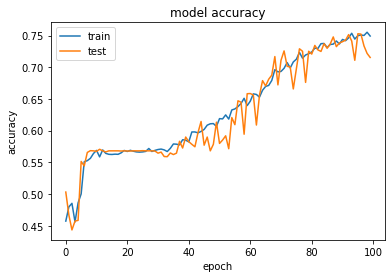

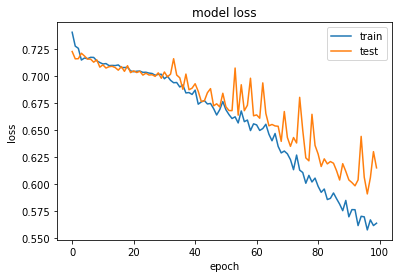

In [14]:
#x_train, x_test, y_train, y_test, batch_size = data()
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
model = load_model('best_model/'+model_name+'.h5')
model.summay()
model.compile(loss='categorical_crossentropy',optimizer=best_run['optimizer'],metrics=['accuracy'])

checkpointer, call_reduce, callback_lr, callback_es, callback_pl, callback_csv = get_callback(early_stopping_count)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

callbacks_list = [checkpointer, call_reduce, callback_es, callback_csv, callback_pl, tensorboard]

history = model.fit(x_train, y_train,batch_size=batch_size, epochs=100,
                    verbose=False, validation_data=(x_test, y_test), callbacks=callbacks_list)

test_score, test_accuracy = best_model.evaluate(x_test, y_test, batch_size=batch_size)
print('test_score: ', test_score, ' test_accuracy: ', test_accuracy)
draw_history()

In [15]:
class_names = ['BUY', 'SELL']


def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    print(cm)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=10)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    #plt.figure(figsize = (10,10))
    plt.savefig('train_model/'+model_name+'.png', facecolor='yellowgreen',bbox_inches='tight', dpi=100)
    plt.show()

[[ 981  567]
 [ 453 1583]]


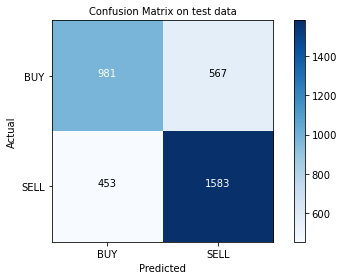

ROC_AUC_SCORE:  0.7056129209119569


In [16]:
prediction_test = (np.argmax(model.predict(x_test, batch_size=1), axis=1))
actual_test = (np.argmax(y_test, axis=1))
cnf_matrix = confusion_matrix(actual_test, prediction_test)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix on test data')
ROC_AUC_SCORE=(roc_auc_score(actual_test, prediction_test))
print('ROC_AUC_SCORE: ',ROC_AUC_SCORE)